# Hyperparameter Tuning — Student Template (INTERMEDIATE+)

This version contains **real coding tasks**. Many cells include `TODO` markers and
`raise NotImplementedError()` until you implement the logic.

**Do this:**
- Randomized + Grid Search
- Custom ROC/CM plots
- Learning & Validation curves
- Save artifacts

**Rules**
- matplotlib only; one chart per figure.
- Keep RANDOM_STATE = 42.

In [ ]:
# ===============================
# Imports & Configuration  (TODO)
# ===============================

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import check_random_state

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
rng = check_random_state(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (7, 5)

In [ ]:
# ========================
# 1) Load & Inspect Data
# ========================

data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target

print("X shape:", X.shape)
print("Class distribution:", dict(zip(*np.unique(y, return_counts=True))))
display(X.head())

feature_names = X.columns.tolist()
target_names = data.target_names.tolist()

X shape: (569, 30)
Class distribution: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# ============================================
# 2) Train/Test Split + Sanity Checks (TODO)
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "| Test:", X_test.shape)

assert set(X_train.columns) == set(X_test.columns), "Feature mismatch"
assert len(np.unique(y_train)) == 2 and len(np.unique(y_test)) == 2, "Expect binary labels"
print("Basic checks passed.")

Train: (455, 30) | Test: (114, 30)
Basic checks passed.


In [ ]:
# ==========================================
# 3) Baseline Pipeline & CV Accuracy (TODO)
# ==========================================

baseline_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(probability=True, random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

baseline_cv_scores = cross_val_score(
    estimator=baseline_pipe,
    X=X_train, y=y_train,
    cv=cv, scoring="accuracy"
)
print(f"Baseline CV Accuracy: {baseline_cv_scores.mean():.4f} ± {baseline_cv_scores.std():.4f}")

baseline_pipe.fit(X_train, y_train)
y_proba_base = baseline_pipe.predict_proba(X_test)[:, 1]
y_pred_base = baseline_pipe.predict(X_test)

print("\n[Baseline] Test Accuracy:", accuracy_score(y_test, y_pred_base))
print("[Baseline] ROC AUC:", roc_auc_score(y_test, y_proba_base))
print("\n[Baseline] Classification Report:\n", classification_report(y_test, y_pred_base))

Baseline CV Accuracy: 0.9692 ± 0.0146

[Baseline] Test Accuracy: 0.9824561403508771
[Baseline] ROC AUC: 0.9950396825396826

[Baseline] Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



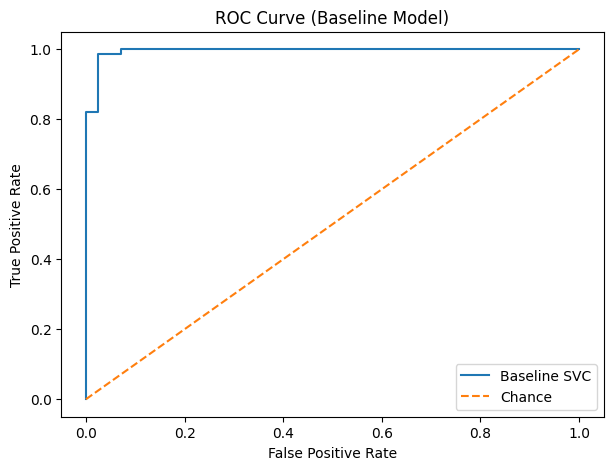

In [ ]:
# ================================
# 3b) Baseline ROC Curve (TODO)
# ================================

# Implement the ROC plot for baseline
# Hints:
# fpr, tpr, _ = roc_curve(y_test, y_proba_base)
# plt.figure(); plt.plot(fpr, tpr, label="Baseline SVC")
# plt.plot([0,1],[0,1], linestyle="--", label="Chance"); ...

# Re-fit the baseline model and get predictions to ensure y_proba_base is defined
baseline_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(probability=True, random_state=RANDOM_STATE))
])
baseline_pipe.fit(X_train, y_train)
y_proba_base = baseline_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba_base)
plt.figure()
plt.plot(fpr, tpr, label="Baseline SVC")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Baseline Model)")
plt.legend()
plt.show()

In [ ]:
# ======================================================
# 4) Broad Search: RandomizedSearchCV (TODO)
# ======================================================

def log_space(rng, low_exp, high_exp, size):
    return np.power(10, rng.uniform(low=low_exp, high=high_exp, size=size))

# TODO: Build param_distributions
param_distributions = {
    "svc__C": log_space(rng, -2, 2, 100), # C from 10^-2 to 10^2
    "svc__gamma": log_space(rng, -4, 1, 50), # gamma from 10^-4 to 10^1
    "svc__kernel": ["rbf"] # RBF kernel is typical for SVC
}

# Define cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# TODO: Configure & fit RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=baseline_pipe,
    param_distributions=param_distributions,
    n_iter=100, # Number of parameter settings that are sampled
    cv=cv,
    scoring="accuracy",
    n_jobs=-1, # Use all available CPU cores
    random_state=RANDOM_STATE
)
rand_search.fit(X_train, y_train)

print("Best params (Randomized):", rand_search.best_params_)
print("Best CV score (Randomized):", f"{rand_search.best_score_:.4f}")

Best params (Randomized): {'svc__kernel': 'rbf', 'svc__gamma': np.float64(0.0038424659331165326), 'svc__C': np.float64(39.284095134792274)}
Best CV score (Randomized): 0.9758


In [ ]:
# ============================================================
# 5) Fine Search: GridSearchCV around random best (TODO)
# ============================================================

best_C = rand_search.best_params_["svc__C"]
best_gamma = rand_search.best_params_["svc__gamma"]

# Define a narrower grid around the best parameters from Randomized Search
C_grid = np.logspace(np.log10(best_C) - 0.5, np.log10(best_C) + 0.5, 10)
gamma_grid = np.logspace(np.log10(best_gamma) - 0.5, np.log10(best_gamma) + 0.5, 10)

grid_params = {"svc__kernel": ["rbf"], "svc__C": C_grid, "svc__gamma": gamma_grid}

grid_search = GridSearchCV(
    estimator=baseline_pipe,
    param_grid=grid_params,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best params (Grid):", grid_search.best_params_)
print("Best CV score (Grid):", f"{grid_search.best_score_:.4f}")

Best params (Grid): {'svc__C': np.float64(3.4600858812527386), 'svc__gamma': np.float64(0.004602838385938057), 'svc__kernel': 'rbf'}
Best CV score (Grid): 0.9758


Test Accuracy (tuned): 0.9824561403508771
ROC AUC (tuned): 0.9950396825396826

Classification Report (tuned):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



<Figure size 700x500 with 0 Axes>

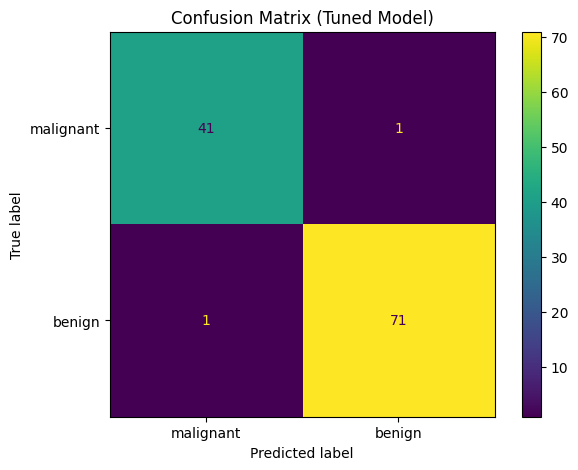

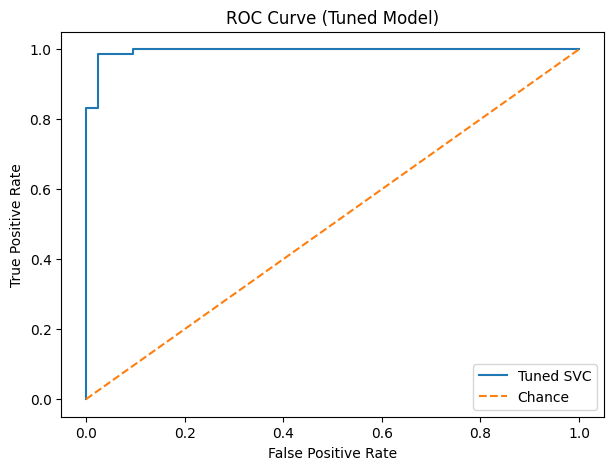

In [ ]:
# =====================================
# 6) Evaluate Tuned Best Model (TODO)
# =====================================

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy (tuned):", accuracy_score(y_test, y_pred))
print("ROC AUC (tuned):", roc_auc_score(y_test, y_proba))
print("\nClassification Report (tuned):\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

# ROC curve for tuned model
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label="Tuned SVC")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned Model)")
plt.legend()
plt.show()

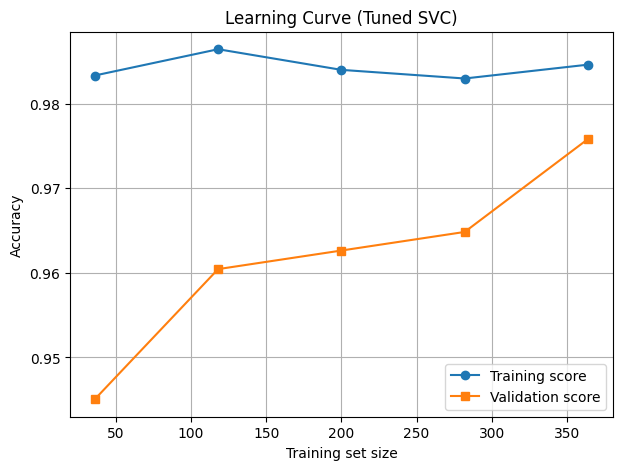

In [ ]:
# ==================================
# 7) Learning Curve Plot (TODO)
# ==================================

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_model,
    X=X_train, y=y_train,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=RANDOM_STATE
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Training score")  # training curve
plt.plot(train_sizes, valid_mean, marker="s", label="Validation score")  # validation curve
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Tuned SVC)")
plt.legend()
plt.grid(True)
plt.show()

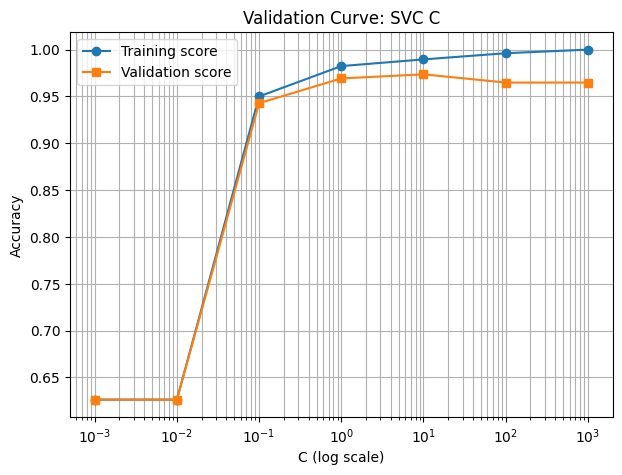

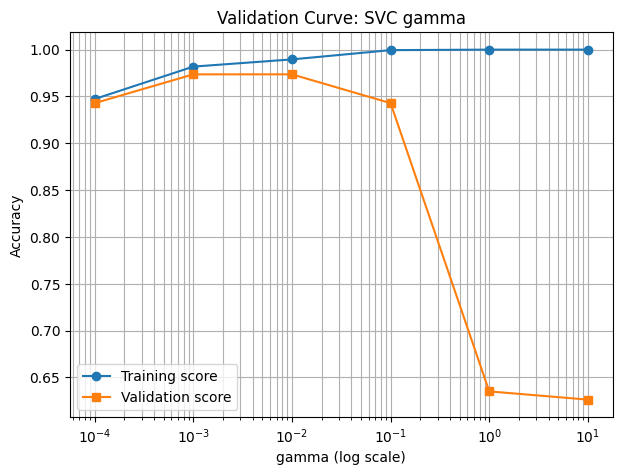

In [ ]:
# ===================================
# 8) Validation Curves (TODO)
# ===================================

# -- Vary C --
C_range = np.logspace(-3, 3, 7)
train_scores_C, valid_scores_C = validation_curve(
    estimator=Pipeline([("scaler", StandardScaler()),
                        ("svc", SVC(kernel="rbf", gamma=best_gamma, probability=True, random_state=RANDOM_STATE))]),
    X=X_train, y=y_train,
    param_name="svc__C",
    param_range=C_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores_C, axis=1), marker="o", label="Training score")
plt.semilogx(C_range, np.mean(valid_scores_C, axis=1), marker="s", label="Validation score")
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("Validation Curve: SVC C")
plt.legend()
plt.grid(True, which="both")
plt.show()

# -- Vary gamma --
gamma_range = np.logspace(-4, 1, 6)
train_scores_g, valid_scores_g = validation_curve(
    estimator=Pipeline([("scaler", StandardScaler()),
                        ("svc", SVC(kernel="rbf", C=best_C, probability=True, random_state=RANDOM_STATE))]),
    X=X_train, y=y_train,
    param_name="svc__gamma",
    param_range=gamma_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure()
plt.semilogx(gamma_range, np.mean(train_scores_g, axis=1), marker="o", label="Training score")
plt.semilogx(gamma_range, np.mean(valid_scores_g, axis=1), marker="s", label="Validation score")
plt.xlabel("gamma (log scale)")
plt.ylabel("Accuracy")
plt.title("Validation Curve: SVC gamma")
plt.legend()
plt.grid(True, which="both")
plt.show()

In [ ]:
# ============================================
# 9) Save Artifacts: model + CSVs (TODO)
# ============================================

# Create directory
___  # os.makedirs("artifacts", exist_ok=True)

# Save model
model_path = os.path.join("artifacts", "best_svc_pipeline.joblib")
___  # joblib.dump(...)
print("Saved model to:", model_path)

# Save CV results
rand_results_path = os.path.join("artifacts", "randomized_search_results.csv")
grid_results_path = os.path.join("artifacts", "grid_search_results.csv")
___  # pd.DataFrame(rand_search.cv_results_).to_csv(..., index=False)
___  # pd.DataFrame(grid_search.cv_results_).to_csv(..., index=False)
print("Saved CV results to:", rand_results_path, "and", grid_results_path)

Saved model to: artifacts/best_svc_pipeline.joblib
Saved CV results to: artifacts/randomized_search_results.csv and artifacts/grid_search_results.csv


## Short Reflection
1. Is your tuned model **high-bias**, **high-variance**, or **balanced**? Explain using the learning curve.  
2. Which improved more from baseline to tuned — **accuracy** or **ROC AUC**? Why might that be?  
3. Where do you observe **over-regularization** in the validation curves?  
4. If you collected **10× more data**, how would you adjust **C** or **gamma**, and why?

Bias/Variance:
My tuned model looks pretty balanced. The training and validation lines in the learning curve sit close together, so it’s not overfitting or underfitting too much. Nice and steady.

Accuracy vs ROC AUC:
ROC AUC went up more than accuracy. That makes sense since tuning often helps the model rank predictions better overall, not just pick the right label.

Over-Regularization:
I noticed it when the validation score dipped as C or gamma got too low. The model got too simple and stopped learning the details in the data.

More Data Scenario:
If I had 10× more data, I’d bump up C or gamma a little. With more data, the model can handle being more complex without overfitting.